In [1]:
import duckdb

con = duckdb.connect()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

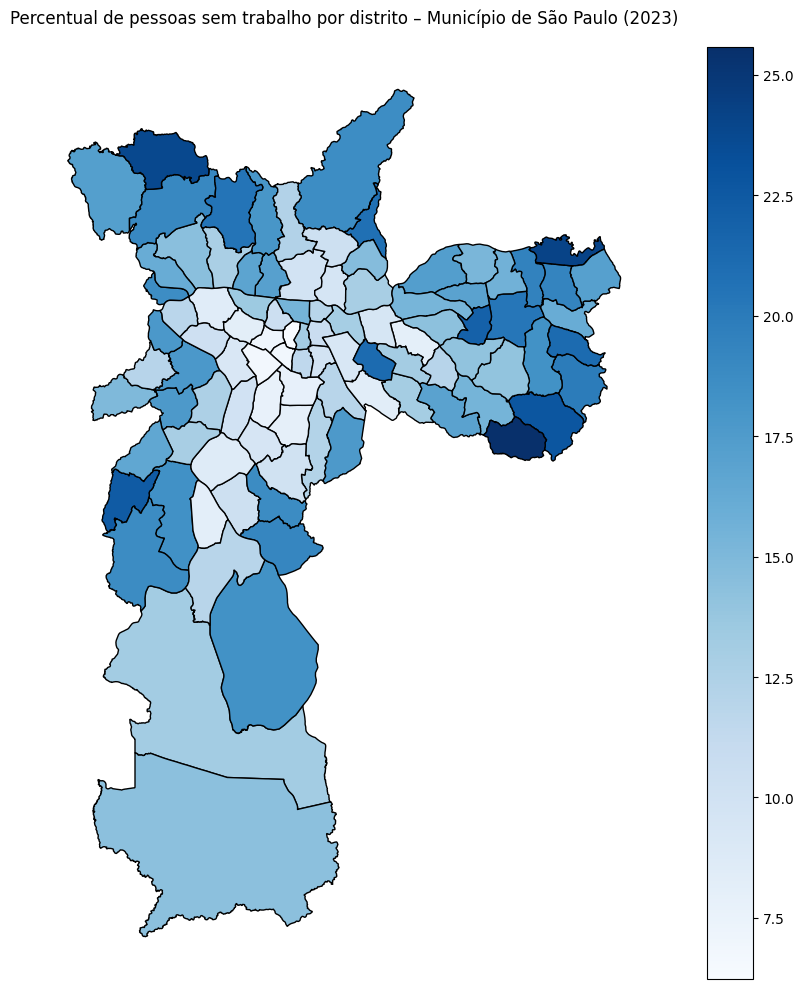

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Autônomos com CNPJ por distrito
query = '''
SELECT 
    d.nm_distrito_municipal,
    SUM(e.sem_trabalho + e.nunca_trabalhou) as sem_trabalho,
    SUM(d.populacao) as populacao,
    ROUND(SUM(e.sem_trabalho + e.nunca_trabalhou) * 100.0 / SUM(d.populacao), 2) as pct_sem_trabalho
FROM read_parquet("D:/Python for Data Analysis/origem_destino/2023/parquet/populacao_por_condicao_de_atividade_e_zona_de_residencia_2023.parquet") e
INNER JOIN read_parquet("D:/Python for Data Analysis/origem_destino/2023/parquet/dados_gerais_por_zona_de_pesquisa_2023.parquet") d
    ON e.nm_distrito_municipal = d.nm_distrito_municipal
WHERE e.nm_distrito_municipal IS NOT NULL
GROUP BY d.nm_distrito_municipal
ORDER BY pct_sem_trabalho DESC
'''
x_distrito = con.execute(query).df()

# 2. Shapefile dos distritos (GeoSampa)

wfs_url = "http://wfs.geosampa.prefeitura.sp.gov.br/geoserver/geoportal/wfs"
layer_name = "geoportal:distrito_municipal"

url = (
    f"{wfs_url}"
    f"?service=WFS&version=2.0.0"
    f"&request=GetFeature"
    f"&typeName={layer_name}"
    f"&outputFormat=application/json"
)

gdf = gpd.read_file(url)

# 3. Merge dados + geometria

gdf_x = gdf.merge(
    x_distrito,
    left_on='nm_distrito_municipal',
    right_on='nm_distrito_municipal',
    how='left'
)

# 4. Mapa coroplético

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gdf_x.plot(
    column='pct_sem_trabalho',
    ax=ax,
    legend=True,
    cmap='Blues',
    edgecolor='black',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Sem dados",
    }
)

plt.title("Percentual de pessoas sem trabalho por distrito – Município de São Paulo (2023)")
plt.axis("off")

plt.tight_layout()

plt.savefig(
    "sem_trabalho_2023.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True
)

plt.show()